![title](images/header.png)

# Vb - Supervised Classification with CAFI data
-------
this notebook performs a supervised classification of probability of forest change for one country using the merged eSBAE and CEO data trained on the interpreted data from CAFI DDD phase I (2015-2020).  
The change probability is then divided into 3 strata using kmeans
The modeled data are exported to csv for the following script to extract samples for validation in CEO.

This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [137]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling


import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

### Parameters

In [165]:
ISO = 'COG'

#### Import the CEO validated data from CAFI DDD first phase - output from script 5a
##### this file includes 13,115 points, randomly distributed over CAFI, with interpretation
##### additional attributes from CAFI rasters have been added (fragmentation, tree cover)
##### this file is available here: https://drive.google.com/file/d/1D1tkVVhKv6QNCQhLLfRo7eqz0VO3XZZF/view?usp=sharing
##### unzip and upload to your SEPAL workspace using Filezilla

In [138]:
trn_ceo = pd.read_csv('/home/sepal-user/module_results/esbae/CAFI/CAFI_esbae_ceo_phaseI_att.csv', delimiter=',')
trn_ceo

,geometry,UniqueID,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,...,sampling,ECO_CODE,ECO_NAME,ECO_NUM,ECODE_NAME,TropBiome,CAFI_LC_2015,Frag_2015,Treecov_2015,Biomass_2010
0,POINT (25.60212035 -11.69188784),1,181,97,2018.589,-738.678406,-1.354781,2016.597,0.111200,45954.212113,...,str_random,AT0704,Central Zambezian Miombo Woodlands,4.0,AT0704. Central Zambezian Miombo woodlands,2.0,2,5,52,94
1,POINT (19.01297774 6.404943059),2,153,90,2016.381,-1332.806396,-1.765601,2020.038,0.318602,53800.048638,...,str_random,AT0712,Northern Congolian Forest-Savanna Mosaic,12.0,AT0712. Northern Congolian forest-savanna mosaic,2.0,9,3,54,194
2,POINT (22.79183081 7.078410027),3,158,93,2016.915,-2419.585449,-2.557598,2020.003,0.116307,48050.450691,...,str_random,AT0705,East Sudanian Savanna,5.0,AT0705. East Sudanian savanna,2.0,11,2,33,9
3,POINT (27.43010212 -6.534839454),4,129,60,-1.000,0.000000,0.000000,2017.430,0.290449,37411.044881,...,str_random,AT0704,Central Zambezian Miombo Woodlands,4.0,AT0704. Central Zambezian Miombo woodlands,2.0,11,2,28,52
4,POINT (22.21214796 -9.940981517),5,140,79,2018.342,13.038783,-0.582325,2018.518,0.164515,32283.895600,...,str_random,AT0704,Central Zambezian Miombo Woodlands,4.0,AT0704. Central Zambezian Miombo woodlands,2.0,2,3,51,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13110,POINT (18.90329319 4.178378347),13112,123,80,-1.000,0.000000,0.000000,2016.468,0.395151,18018.418333,...,str_random,AT0124,Northeastern Congolian Lowland Forests,24.0,AT0124. Northeastern Congolian lowland forests,1.0,1,2,41,38
13111,POINT (17.17745164 -5.075794729),13113,113,63,2017.433,-750.342834,-1.426068,2018.485,0.284138,7684.125926,...,str_random,AT0718,Southern Congolian Forest-Savanna Mosaic,18.0,AT0718. Southern Congolian forest-savanna mosaic,2.0,1,2,59,39
13112,POINT (21.96690965 3.213589406),13114,116,67,2017.219,-84.756882,-0.863496,2018.118,0.284414,5417.638273,...,str_random,AT0124,Northeastern Congolian Lowland Forests,24.0,AT0124. Northeastern Congolian lowland forests,1.0,1,2,70,392
13113,POINT (27.81844527 -3.425142538),13115,134,71,2016.816,362.227112,0.848210,2020.036,0.562147,9395.833300,...,str_random,AT0124,Northeastern Congolian Lowland Forests,24.0,AT0124. Northeastern Congolian lowland forests,1.0,1,2,75,180


In [139]:
print(trn_ceo.columns.values)

['geometry' 'UniqueID' 'images' 'mon_images' 'bfast_change_date'
 'bfast_magnitude' 'bfast_means' 'cusum_change_date' 'cusum_confidence'
 'cusum_magnitude' 'red_mean' 'red_sd' 'red_min' 'red_max' 'nir_mean'
 'nir_sd' 'nir_min' 'nir_max' 'swir1_mean' 'swir1_sd' 'swir1_min'
 'swir1_max' 'swir2_mean' 'swir2_sd' 'swir2_min' 'swir2_max' 'ndfi_mean'
 'ndfi_sd' 'ndfi_min' 'ndfi_max' 'brightness_mean' 'brightness_sd'
 'brightness_min' 'brightness_max' 'greenness_mean' 'greenness_sd'
 'greenness_min' 'greenness_max' 'wetness_mean' 'wetness_sd' 'wetness_min'
 'wetness_max' 'bs_slope_mean' 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min'
 'ewma_jrc_date' 'ewma_jrc_change' 'ewma_jrc_magnitude' 'mosum_jrc_date'
 'mosum_jrc_change' 'mosum_jrc_magnitude' 'cusum_jrc_date'
 'cusum_jrc_change' 'cusum_jrc_magnitude' 'ccdc_change_date'
 'ccdc_magnitude' 'aspect' 'dw_class_mode' 'dw_tree_prob__max'
 'dw_tree_prob__min' 'dw_tree_prob__stdDev' 'dw_tree_prob_mean'
 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17' 'es

In [140]:
trn_gdf = gpd.GeoDataFrame(trn_ceo, geometry=gpd.points_from_xy(trn_ceo.LON, trn_ceo.LAT))

### Augmented dataset for country of interest (2015-2022)
#### this is the output folder from eSBAE script 4

In [187]:
# glob all files in the data augmentation output folder
#files = Path('/home/sepal-user/module_results/esbae/GAB/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/DRC/04_Dataset_Augmentation/Landsat/').glob('*geojson')
files = Path('/home/sepal-user/module_results/esbae/COG/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/EQG/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/CMR/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/CAR/04_Dataset_Augmentation/Landsat/').glob('*geojson')

#### name of output file
##### this file consists of the eSBAE data for your country with a modeled change probability using CAFI phase I data

In [188]:
all_points_out_file = '/home/sepal-user/module_results/esbae/COG/COG_esbae_1520_model.csv'

In [189]:
parquet_out = '/home/sepal-user/module_results/esbae/COG/COG_esbae.parquet'

In [190]:
# eSBAE columns for analysis
eSBAE_analysis = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    'images', 'mon_images', 'bfast_change_date',
      # 'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope',
       'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020',
       'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 'CAFI_LC_2015','Frag_2015', 'Treecov_2015', 'Biomass_2010']

In [191]:
#eSBAE columns to include in data export
cols_to_export = ['geometry', 'UniqueID',
                  #'dates', 'ts',
                  'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope',
       'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020',
       'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub','CAFI_LC_2015','Frag_2015', 'Treecov_2015', 'Biomass_2010']

#### end of parameters

# 1 - CEO data preparation
### 1.1 - Import CEO interpreted data

In [192]:
len(trn_gdf.index)

13115

### 1.2 - Inspect CEO interpreted data

Our ultimate goal is to use the CEO data for getting the probability of forest change via a series of classifications and their probability output. . , i.e. Forest-Non-Forest and a Change-No-Change classifcation.
Therefore we need to extract and trnasform the relevant information into a column of 0s and 1s. 

First let's look at the columns the CEO file contains.

In [193]:
trn_gdf.columns.tolist()

['geometry',
 'UniqueID',
 'images',
 'mon_images',
 'bfast_change_date',
 'bfast_magnitude',
 'bfast_means',
 'cusum_change_date',
 'cusum_confidence',
 'cusum_magnitude',
 'red_mean',
 'red_sd',
 'red_min',
 'red_max',
 'nir_mean',
 'nir_sd',
 'nir_min',
 'nir_max',
 'swir1_mean',
 'swir1_sd',
 'swir1_min',
 'swir1_max',
 'swir2_mean',
 'swir2_sd',
 'swir2_min',
 'swir2_max',
 'ndfi_mean',
 'ndfi_sd',
 'ndfi_min',
 'ndfi_max',
 'brightness_mean',
 'brightness_sd',
 'brightness_min',
 'brightness_max',
 'greenness_mean',
 'greenness_sd',
 'greenness_min',
 'greenness_max',
 'wetness_mean',
 'wetness_sd',
 'wetness_min',
 'wetness_max',
 'bs_slope_mean',
 'bs_slope_sd',
 'bs_slope_max',
 'bs_slope_min',
 'ewma_jrc_date',
 'ewma_jrc_change',
 'ewma_jrc_magnitude',
 'mosum_jrc_date',
 'mosum_jrc_change',
 'mosum_jrc_magnitude',
 'cusum_jrc_date',
 'cusum_jrc_change',
 'cusum_jrc_magnitude',
 'ccdc_change_date',
 'ccdc_magnitude',
 'aspect',
 'dw_class_mode',
 'dw_tree_prob__max',
 'dw_tr

In [194]:
trn_gdf['UniqueID'].nunique(dropna=False)

13115

### 1.3 Print unique values for columns of interest generate Change-No Change

In [195]:
# show unique values for the columns (in red)
print('Change', trn_ceo['Ref_Change_Type_1520'].unique())

Change ['Deg' 'Stable' 'NF' 'Def']


In [196]:
# add stable forest column for classification
trn_gdf['Change_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'Def' or  x == 'Deg' else 0)
np.unique(trn_gdf['Change_Bin'], return_counts=True)

(array([0, 1]), array([9275, 3840]))

In [197]:
# add stable forest column for classification
trn_gdf['Stable_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'Stable' else 0)
np.unique(trn_gdf['Stable_Bin'], return_counts=True)

(array([0, 1]), array([8446, 4669]))

In [198]:
# add def column for classification
trn_gdf['Def_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'Def' else 0)
np.unique(trn_gdf['Def_Bin'], return_counts=True)

(array([0, 1]), array([10574,  2541]))

In [199]:
# add def column for classification
trn_gdf['Deg_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'Deg' else 0)
np.unique(trn_gdf['Deg_Bin'], return_counts=True)

(array([0, 1]), array([11816,  1299]))

In [200]:
# add NF column for classification
trn_gdf['NF_Bin'] = trn_gdf['Ref_Change_Type_1520'].apply(lambda x: 1 if x == 'NF' else 0)
np.unique(trn_gdf['NF_Bin'], return_counts=True)

(array([0, 1]), array([8509, 4606]))

In [201]:
trn_gdf.head()

,geometry,UniqueID,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,...,TropBiome,CAFI_LC_2015,Frag_2015,Treecov_2015,Biomass_2010,Change_Bin,Stable_Bin,Def_Bin,Deg_Bin,NF_Bin
0,POINT (25.60212 -11.69189),1,181,97,2018.589,-738.678406,-1.354781,2016.597,0.111200,45954.212113,...,2.0,2,5,52,94,1,0,0,1,0
1,POINT (19.01298 6.40494),2,153,90,2016.381,-1332.806396,-1.765601,2020.038,0.318602,53800.048638,...,2.0,9,3,54,194,1,0,0,1,0
2,POINT (22.79183 7.07841),3,158,93,2016.915,-2419.585449,-2.557598,2020.003,0.116307,48050.450691,...,2.0,11,2,33,9,1,0,0,1,0
3,POINT (27.43010 -6.53484),4,129,60,-1.000,0.000000,0.000000,2017.430,0.290449,37411.044881,...,2.0,11,2,28,52,0,1,0,0,0
4,POINT (22.21215 -9.94098),5,140,79,2018.342,13.038783,-0.582325,2018.518,0.164515,32283.895600,...,2.0,2,3,51,87,0,1,0,0,0


# 2 - Join CEO and Time-Series data

### 2.1 - Load data augmented time-series data from script 4
area must intersect with the CAFI region

In [202]:
# prepare for parallel execution
files = [[str(file), False] for file in files]

# read files in parallel nad put the in a list
result = py_helpers.run_in_parallel(
    py_helpers.geojson_to_gdf,
    files,
    workers=4,
    parallelization='processes'
)

# concatenate dataframes from result's list
cdf = pd.concat(result)

In [203]:
#save file
cdf.to_parquet(parquet_out)

In [204]:
#if you already ran this step you can read the parquet file
#pd.read_parquet(parquet_out)

In [205]:
len(cdf.index)

291595

In [206]:
print(cdf.columns)

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'a

In [207]:
print(trn_gdf.columns)

Index(['geometry', 'UniqueID', 'images', 'mon_images', 'bfast_change_date',
       'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude',
       ...
       'TropBiome', 'CAFI_LC_2015', 'Frag_2015', 'Treecov_2015',
       'Biomass_2010', 'Change_Bin', 'Stable_Bin', 'Def_Bin', 'Deg_Bin',
       'NF_Bin'],
      dtype='object', length=142)


In [208]:
print(trn_ceo.columns)

Index(['geometry', 'UniqueID', 'images', 'mon_images', 'bfast_change_date',
       'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude',
       ...
       'sampling', 'ECO_CODE', 'ECO_NAME', 'ECO_NUM', 'ECODE_NAME',
       'TropBiome', 'CAFI_LC_2015', 'Frag_2015', 'Treecov_2015',
       'Biomass_2010'],
      dtype='object', length=137)


### 2.2 - add raster attributes

In [209]:
LC_map = "/home/sepal-user/data/lc_map/CAFI_LC_2015_19_wgs84.tif"

In [210]:
LC_src = rasterio.open(LC_map)

In [211]:
frag_map = "/home/sepal-user/data/other_data/cafi_frag_wgs84.tif"

In [212]:
frag_src = rasterio.open(frag_map)

In [213]:
treecov = "/home/sepal-user/data/other_data/treecover_2015_1ha_wgs84.tif"

In [214]:
tree_src = rasterio.open(treecov)

In [215]:
biomass = "/home/sepal-user/data/other_data/ESA_Biomass_2010.tif"

In [216]:
biomass_src =  rasterio.open(biomass)

In [217]:
coord_list = [(x, y) for x, y in zip(cdf["geometry"].x, cdf["geometry"].y)]

In [218]:
cdf["CAFI_LC_2015"] = [x for x in LC_src.sample(coord_list)]
cdf["CAFI_LC_2015"] = cdf["CAFI_LC_2015"].str[0]
cdf.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,tmf_2018,tmf_2019,tmf_2020,tmf_2021,tmf_2022,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,CAFI_LC_2015
0,POINT (12.95157 -3.37544),722204,"[20100820, 20110908, 20130804, 20140324, 20140...","{'green': [1278.177491001641, 440.616317989057...",33,24,2016.068,-1609.672119,-4.288966,2023.252,...,1,1,1,1,1,0,0,10,10,1
1,POINT (12.93664 -3.38505),722186,"[20100820, 20120724, 20130804, 20140503, 20140...","{'green': [1113.3578174662268, 387.95298335341...",35,25,2016.068,2657.211914,5.709590,2023.186,...,1,1,1,1,1,0,0,10,10,1
2,POINT (12.95652 -3.36582),722205,"[20101124, 20110908, 20120724, 20140324, 20140...","{'green': [448.27178607557454, 415.69124723266...",36,26,2016.967,-136.847305,-0.127688,2020.033,...,1,1,1,1,1,0,0,10,10,1
3,POINT (12.95660 -3.38506),722217,"[20101124, 20110908, 20120724, 20130201, 20130...","{'green': [1222.337207391393, 460.090160866454...",46,30,2020.230,-1299.135254,-1.063894,2019.616,...,1,1,1,1,1,0,0,10,10,1
4,POINT (12.94159 -3.37543),722187,"[20110503, 20120724, 20120809, 20130804, 20140...","{'green': [449.6740329611105, 411.245477988350...",36,25,2016.967,-1174.866211,-0.788893,2020.340,...,1,1,1,1,1,0,0,10,10,3


In [219]:
cdf["Frag_2015"] = [x for x in frag_src.sample(coord_list)]
cdf["Frag_2015"] = cdf["Frag_2015"].str[0]
cdf.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,tmf_2019,tmf_2020,tmf_2021,tmf_2022,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,CAFI_LC_2015,Frag_2015
0,POINT (12.95157 -3.37544),722204,"[20100820, 20110908, 20130804, 20140324, 20140...","{'green': [1278.177491001641, 440.616317989057...",33,24,2016.068,-1609.672119,-4.288966,2023.252,...,1,1,1,1,0,0,10,10,1,5
1,POINT (12.93664 -3.38505),722186,"[20100820, 20120724, 20130804, 20140503, 20140...","{'green': [1113.3578174662268, 387.95298335341...",35,25,2016.068,2657.211914,5.709590,2023.186,...,1,1,1,1,0,0,10,10,1,5
2,POINT (12.95652 -3.36582),722205,"[20101124, 20110908, 20120724, 20140324, 20140...","{'green': [448.27178607557454, 415.69124723266...",36,26,2016.967,-136.847305,-0.127688,2020.033,...,1,1,1,1,0,0,10,10,1,5
3,POINT (12.95660 -3.38506),722217,"[20101124, 20110908, 20120724, 20130201, 20130...","{'green': [1222.337207391393, 460.090160866454...",46,30,2020.230,-1299.135254,-1.063894,2019.616,...,1,1,1,1,0,0,10,10,1,5
4,POINT (12.94159 -3.37543),722187,"[20110503, 20120724, 20120809, 20130804, 20140...","{'green': [449.6740329611105, 411.245477988350...",36,25,2016.967,-1174.866211,-0.788893,2020.340,...,1,1,1,1,0,0,10,10,3,5


In [220]:
cdf["Treecov_2015"] = [x for x in tree_src.sample(coord_list)]
cdf["Treecov_2015"] = cdf["Treecov_2015"].str[0]
cdf.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,tmf_2020,tmf_2021,tmf_2022,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,CAFI_LC_2015,Frag_2015,Treecov_2015
0,POINT (12.95157 -3.37544),722204,"[20100820, 20110908, 20130804, 20140324, 20140...","{'green': [1278.177491001641, 440.616317989057...",33,24,2016.068,-1609.672119,-4.288966,2023.252,...,1,1,1,0,0,10,10,1,5,87
1,POINT (12.93664 -3.38505),722186,"[20100820, 20120724, 20130804, 20140503, 20140...","{'green': [1113.3578174662268, 387.95298335341...",35,25,2016.068,2657.211914,5.709590,2023.186,...,1,1,1,0,0,10,10,1,5,88
2,POINT (12.95652 -3.36582),722205,"[20101124, 20110908, 20120724, 20140324, 20140...","{'green': [448.27178607557454, 415.69124723266...",36,26,2016.967,-136.847305,-0.127688,2020.033,...,1,1,1,0,0,10,10,1,5,88
3,POINT (12.95660 -3.38506),722217,"[20101124, 20110908, 20120724, 20130201, 20130...","{'green': [1222.337207391393, 460.090160866454...",46,30,2020.230,-1299.135254,-1.063894,2019.616,...,1,1,1,0,0,10,10,1,5,81
4,POINT (12.94159 -3.37543),722187,"[20110503, 20120724, 20120809, 20130804, 20140...","{'green': [449.6740329611105, 411.245477988350...",36,25,2016.967,-1174.866211,-0.788893,2020.340,...,1,1,1,0,0,10,10,3,5,89


In [221]:
cdf["Biomass_2010"] = [x for x in biomass_src.sample(coord_list)]
cdf["Biomass_2010"] = cdf["Biomass_2010"].str[0]
cdf.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,tmf_2021,tmf_2022,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,CAFI_LC_2015,Frag_2015,Treecov_2015,Biomass_2010
0,POINT (12.95157 -3.37544),722204,"[20100820, 20110908, 20130804, 20140324, 20140...","{'green': [1278.177491001641, 440.616317989057...",33,24,2016.068,-1609.672119,-4.288966,2023.252,...,1,1,0,0,10,10,1,5,87,274
1,POINT (12.93664 -3.38505),722186,"[20100820, 20120724, 20130804, 20140503, 20140...","{'green': [1113.3578174662268, 387.95298335341...",35,25,2016.068,2657.211914,5.709590,2023.186,...,1,1,0,0,10,10,1,5,88,295
2,POINT (12.95652 -3.36582),722205,"[20101124, 20110908, 20120724, 20140324, 20140...","{'green': [448.27178607557454, 415.69124723266...",36,26,2016.967,-136.847305,-0.127688,2020.033,...,1,1,0,0,10,10,1,5,88,260
3,POINT (12.95660 -3.38506),722217,"[20101124, 20110908, 20120724, 20130201, 20130...","{'green': [1222.337207391393, 460.090160866454...",46,30,2020.230,-1299.135254,-1.063894,2019.616,...,1,1,0,0,10,10,1,5,81,425
4,POINT (12.94159 -3.37543),722187,"[20110503, 20120724, 20120809, 20130804, 20140...","{'green': [449.6740329611105, 411.245477988350...",36,25,2016.967,-1174.866211,-0.788893,2020.340,...,1,1,0,0,10,10,3,5,89,156


In [222]:
print(cdf.columns)

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'a

### 2.3 - Make a union with training data

In [223]:
db = pd.concat([cdf, trn_gdf], ignore_index=True)

In [224]:
len(db.index)

304710

In [225]:
db.head()

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,ECO_CODE,ECO_NAME,ECO_NUM,ECODE_NAME,TropBiome,Change_Bin,Stable_Bin,Def_Bin,Deg_Bin,NF_Bin
0,POINT (12.95157 -3.37544),722204.0,"[20100820, 20110908, 20130804, 20140324, 20140...","{'green': [1278.177491001641, 440.616317989057...",33,24,2016.068,-1609.672119,-4.288966,2023.252,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (12.93664 -3.38505),722186.0,"[20100820, 20120724, 20130804, 20140503, 20140...","{'green': [1113.3578174662268, 387.95298335341...",35,25,2016.068,2657.211914,5.709590,2023.186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (12.95652 -3.36582),722205.0,"[20101124, 20110908, 20120724, 20140324, 20140...","{'green': [448.27178607557454, 415.69124723266...",36,26,2016.967,-136.847305,-0.127688,2020.033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (12.95660 -3.38506),722217.0,"[20101124, 20110908, 20120724, 20130201, 20130...","{'green': [1222.337207391393, 460.090160866454...",46,30,2020.230,-1299.135254,-1.063894,2019.616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (12.94159 -3.37543),722187.0,"[20110503, 20120724, 20120809, 20130804, 20140...","{'green': [449.6740329611105, 411.245477988350...",36,25,2016.967,-1174.866211,-0.788893,2020.340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
print(db.columns.values)

['geometry' 'point_id' 'dates' 'ts' 'images' 'mon_images'
 'bfast_change_date' 'bfast_magnitude' 'bfast_means' 'cusum_change_date'
 'cusum_confidence' 'cusum_magnitude' 'red_mean' 'red_sd' 'red_min'
 'red_max' 'nir_mean' 'nir_sd' 'nir_min' 'nir_max' 'swir1_mean' 'swir1_sd'
 'swir1_min' 'swir1_max' 'swir2_mean' 'swir2_sd' 'swir2_min' 'swir2_max'
 'ndfi_mean' 'ndfi_sd' 'ndfi_min' 'ndfi_max' 'brightness_mean'
 'brightness_sd' 'brightness_min' 'brightness_max' 'greenness_mean'
 'greenness_sd' 'greenness_min' 'greenness_max' 'wetness_mean'
 'wetness_sd' 'wetness_min' 'wetness_max' 'bs_slope_mean' 'bs_slope_sd'
 'bs_slope_max' 'bs_slope_min' 'ewma_jrc_date' 'ewma_jrc_change'
 'ewma_jrc_magnitude' 'mosum_jrc_date' 'mosum_jrc_change'
 'mosum_jrc_magnitude' 'cusum_jrc_date' 'cusum_jrc_change'
 'cusum_jrc_magnitude' 'ccdc_change_date' 'ccdc_magnitude' 'aspect'
 'dw_class_mode' 'dw_tree_prob__max' 'dw_tree_prob__min'
 'dw_tree_prob__stdDev' 'dw_tree_prob_mean' 'elevation' 'esa_lc20'
 'esa_lc21' '

In [227]:
len(cdf.index)+len(trn_gdf.index) == len(db.index)

True

### 2.4 Check the amount of ground truth data we have for each class

In [228]:
db['Change_Bin'].value_counts(dropna=False)

Change_Bin
NaN    291595
0.0      9275
1.0      3840
Name: count, dtype: int64

In [229]:
db['Def_Bin'].value_counts(dropna=False)

Def_Bin
NaN    291595
0.0     10574
1.0      2541
Name: count, dtype: int64

In [230]:
db['Deg_Bin'].value_counts(dropna=False)

Deg_Bin
NaN    291595
0.0     11816
1.0      1299
Name: count, dtype: int64

## 3. Run change/no-change classification

In [231]:
# predictors used change/nochange classification
db['chg_prob_cafi1520'] = clf.binary_probability_classification(db, 'Change_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.7889439573008006


In [232]:
# predictors used change/nochange classification
db['def_prob_cafi1520'] = clf.binary_probability_classification(db, 'Def_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.7607319862752573


In [233]:
# predictors used change/nochange classification
db['deg_prob_cafi1520'] = clf.binary_probability_classification(db, 'Deg_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.6882195958825772


In [234]:
# predictors used change/nochange classification
db['stable_prob_cafi1520'] = clf.binary_probability_classification(db, 'Stable_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.8552039649256576


In [235]:
clf_db = db[db["point_id"] > 0]

### 3.1 plot the change probability
a good model will have many points with low probability of change, and then very few points with higher probabilites

array([<Axes: title={'center': 'chg_prob_cafi1520'}>], dtype=object)

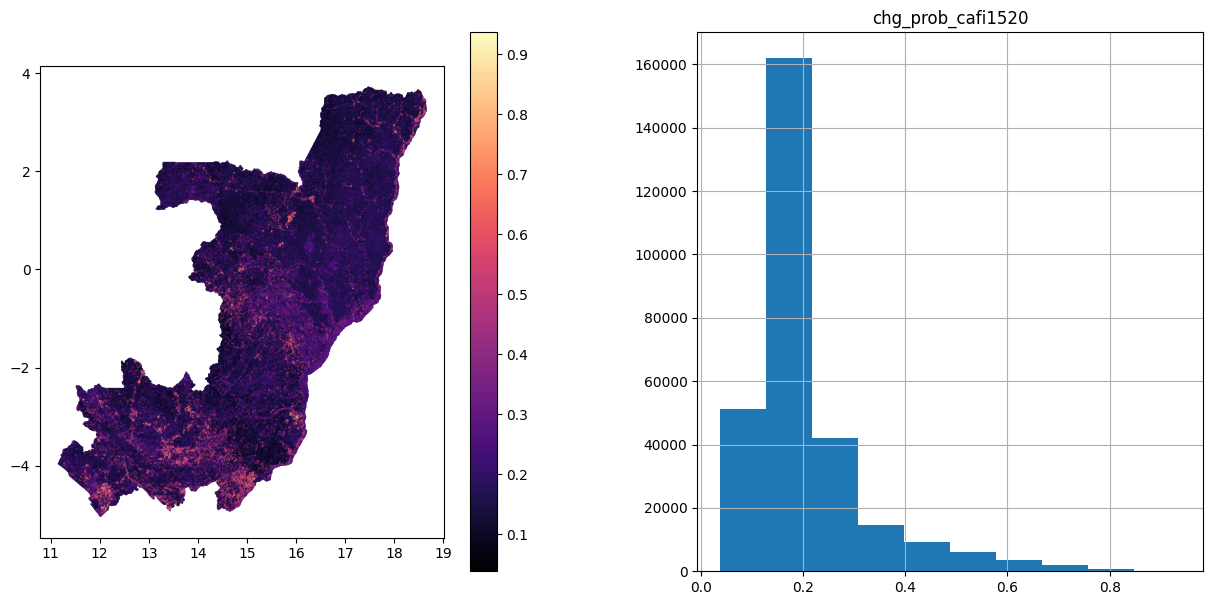

In [236]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('chg_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('chg_prob_cafi1520', ax=ax[1])

array([<Axes: title={'center': 'def_prob_cafi1520'}>], dtype=object)

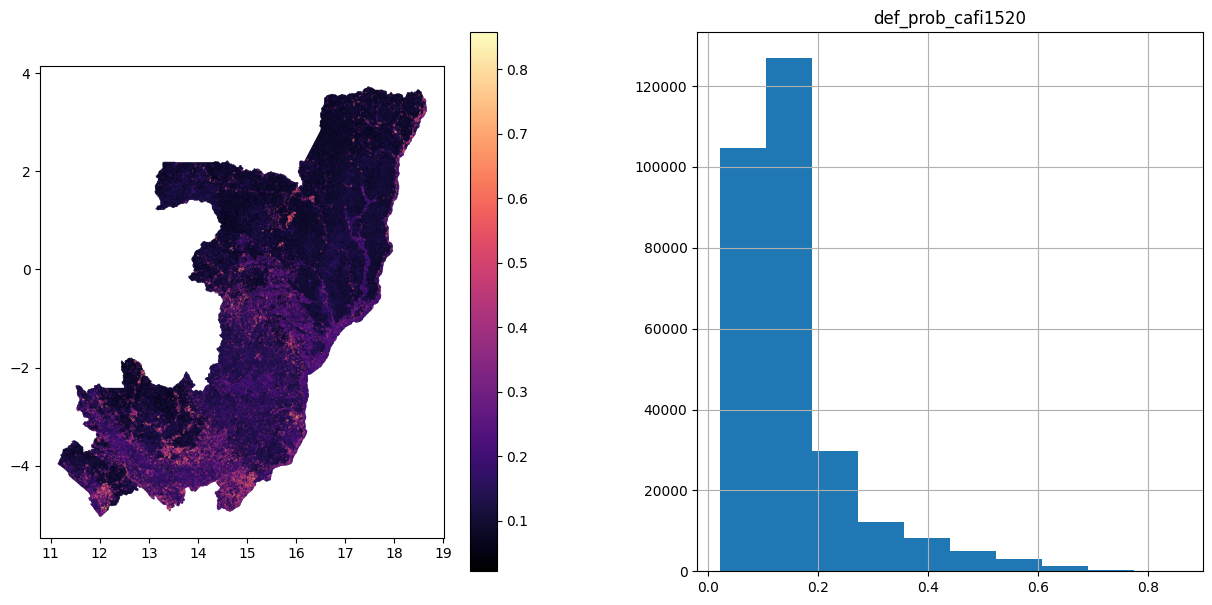

In [237]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('def_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('def_prob_cafi1520', ax=ax[1])

array([<Axes: title={'center': 'deg_prob_cafi1520'}>], dtype=object)

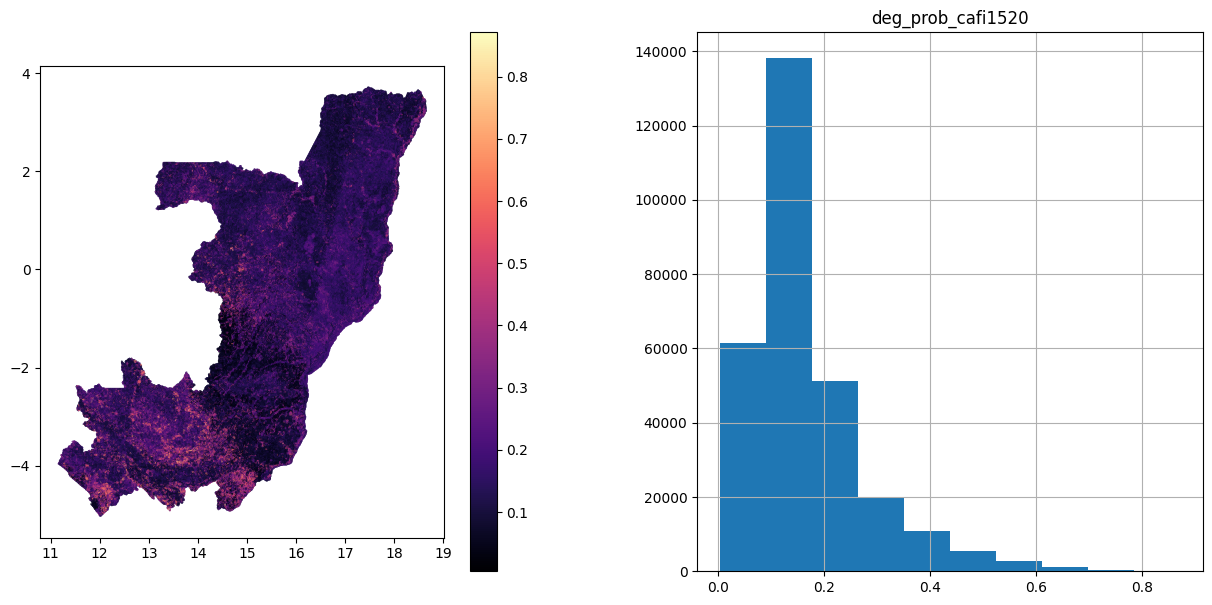

In [238]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('deg_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('deg_prob_cafi1520', ax=ax[1])

array([<Axes: title={'center': 'stable_prob_cafi1520'}>], dtype=object)

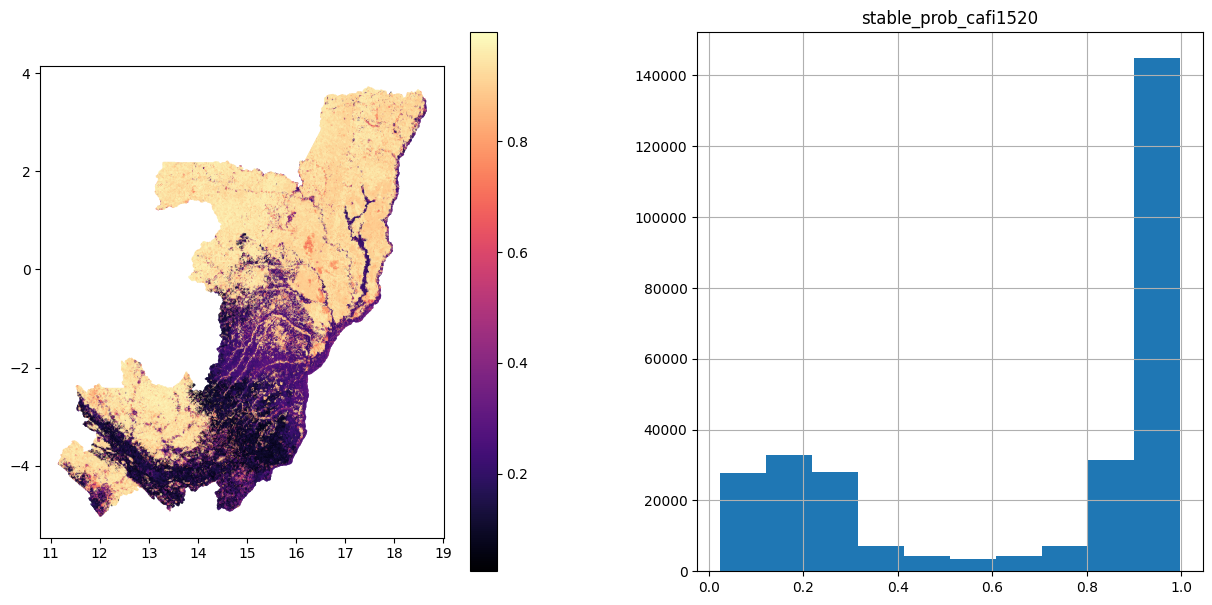

In [239]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('stable_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('stable_prob_cafi1520', ax=ax[1])

In [240]:
clf_db.columns

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date',
       ...
       'TropBiome', 'Change_Bin', 'Stable_Bin', 'Def_Bin', 'Deg_Bin', 'NF_Bin',
       'chg_prob_cafi1520', 'def_prob_cafi1520', 'deg_prob_cafi1520',
       'stable_prob_cafi1520'],
      dtype='object', length=151)

In [241]:
joined_df = clf_db

In [242]:
len(joined_df)

291595

In [243]:
joined_df

,geometry,point_id,dates,ts,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,...,TropBiome,Change_Bin,Stable_Bin,Def_Bin,Deg_Bin,NF_Bin,chg_prob_cafi1520,def_prob_cafi1520,deg_prob_cafi1520,stable_prob_cafi1520
0,POINT (12.95157 -3.37544),722204.0,"[20100820, 20110908, 20130804, 20140324, 20140...","{'green': [1278.177491001641, 440.616317989057...",33,24,2016.068,-1609.672119,-4.288966,2023.252,...,NaN,NaN,NaN,NaN,NaN,NaN,0.136667,0.091333,0.104667,0.967333
1,POINT (12.93664 -3.38505),722186.0,"[20100820, 20120724, 20130804, 20140503, 20140...","{'green': [1113.3578174662268, 387.95298335341...",35,25,2016.068,2657.211914,5.709590,2023.186,...,NaN,NaN,NaN,NaN,NaN,NaN,0.224667,0.149333,0.222667,0.931333
2,POINT (12.95652 -3.36582),722205.0,"[20101124, 20110908, 20120724, 20140324, 20140...","{'green': [448.27178607557454, 415.69124723266...",36,26,2016.967,-136.847305,-0.127688,2020.033,...,NaN,NaN,NaN,NaN,NaN,NaN,0.163333,0.130667,0.143333,0.977333
3,POINT (12.95660 -3.38506),722217.0,"[20101124, 20110908, 20120724, 20130201, 20130...","{'green': [1222.337207391393, 460.090160866454...",46,30,2020.230,-1299.135254,-1.063894,2019.616,...,NaN,NaN,NaN,NaN,NaN,NaN,0.174000,0.132667,0.202667,0.962000
4,POINT (12.94159 -3.37543),722187.0,"[20110503, 20120724, 20120809, 20130804, 20140...","{'green': [449.6740329611105, 411.245477988350...",36,25,2016.967,-1174.866211,-0.788893,2020.340,...,NaN,NaN,NaN,NaN,NaN,NaN,0.191333,0.106667,0.293333,0.952667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291590,POINT (15.76339 -0.64832),969276.0,"[20100218, 20101016, 20101219, 20110410, 20110...","{'green': [450.9352743048008, 460.088282058589...",198,133,2021.173,-15.130913,-0.653003,2020.605,...,NaN,NaN,NaN,NaN,NaN,NaN,0.155333,0.104667,0.078667,0.877333
291591,POINT (15.76827 -0.63865),969277.0,"[20100218, 20100610, 20101219, 20110221, 20110...","{'green': [444.9417782271548, 393.826630155743...",195,130,2020.496,-159.108017,-1.343175,2021.041,...,NaN,NaN,NaN,NaN,NaN,NaN,0.226667,0.154000,0.212667,0.870000
291592,POINT (15.76842 -0.65800),969346.0,"[20100218, 20100610, 20101219, 20110613, 20110...","{'green': [824.2892588904664, 376.785570557230...",183,119,2016.575,-56.009338,-2.057287,2020.956,...,NaN,NaN,NaN,NaN,NaN,NaN,0.161333,0.092000,0.150667,0.919333
291593,POINT (15.75289 -0.57094),968887.0,"[20100610, 20101016, 20101219, 20110205, 20110...","{'green': [340.92366475909597, 466.23803659119...",175,112,-1.000,0.000000,0.000000,2016.532,...,NaN,NaN,NaN,NaN,NaN,NaN,0.341333,0.144667,0.308000,0.672667


### 3.2 Stratify with Kmeans

In [244]:
sample_size_no = 10000

In [245]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'chg_prob_cafi1520', strata=3, sample_size=sample_size_no)

In [246]:
joined_df['kmeans_chg'] = joined_df['stratum']

In [ ]:
h.plot_cluster(joined_df, prob_column='chg_prob_cafi1520', strata_column='kmeans_chg')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_chg', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_chg', ax=ax[1], bins=50)
samples

In [ ]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'def_prob_cafi1520', strata=3, sample_size=sample_size_no)

In [ ]:
joined_df['kmeans_def'] = joined_df['stratum']

In [ ]:
h.plot_cluster(joined_df, prob_column='def_prob_cafi1520', strata_column='kmeans_def')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_def', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_def', ax=ax[1], bins=50)
samples

In [ ]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'deg_prob_cafi1520', strata=3, sample_size=sample_size_no)

In [ ]:
joined_df['kmeans_deg'] = joined_df['stratum']

In [ ]:
h.plot_cluster(joined_df, prob_column='deg_prob_cafi1520', strata_column='kmeans_deg')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_deg', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_deg', ax=ax[1], bins=50)
samples

In [ ]:
cross_tab = pd.crosstab(index= joined_df['kmeans_def'], columns=joined_df['kmeans_deg'], margins=True, margins_name="Total")
cross_tab

In [ ]:
pd.pivot_table(joined_df,values='point_id',index=['kmeans_chg'],aggfunc="count", margins=True)

### 4. align column names, get coordinates


In [ ]:
joined_df['PLOTID'] = joined_df['point_id']

In [ ]:
joined_df.columns.tolist()

In [ ]:
#joined_df.drop(columns='stratum', inplace=True)

In [ ]:
joined_df['LON'] = joined_df.geometry.apply(lambda p: p.x)
joined_df['LAT'] = joined_df.geometry.apply(lambda p: p.y)

### 5. export the points for your area with the change probability model

In [ ]:
joined_df.to_csv(all_points_out_file,index=False)

### now you may proceed to script 5c if you want to extract sample points for CEO